In [1]:
INSTALL = false
if INSTALL
    import Pkg
    Pkg.add("PkgServerClient")
    using PkgServerClient
    PkgServerClient.set_mirror("NJU")
    Pkg.add("JSON3")
    Pkg.add("DataFrames")
    Pkg.add("JSONTables")
    Pkg.add("Plots")
    Pkg.add("Interpolations")
    Pkg.add("FuzzyLogic")
end

In [2]:
TargetPair = Tuple{Int, Int, Int} # x, y, speed
FILE_INDEX = 6
SEG_INDEX = 1

1

In [3]:
import JSON3
FILES_R = [
    "open_close_auto_radar_20240510_173207_88ms.jsonl",
    "open_close_auto_radar_20240510_173300_88ms.jsonl",
    "open_close_auto_radar_20240510_173518_88ms.jsonl",
    "move_vertical_short_20240510_112316_88ms.jsonl",
    "radar_20240510_113056_88ms.jsonl",
    "still_relative_short_20240510_112749_88ms.jsonl",
]
FILES = [
    joinpath(@__DIR__, "data", f) for f in FILES_R
]
FILE_NAME = FILES[FILE_INDEX]
global_targets::Vector{Array{TargetPair}} = []
# JSON3.readjsonlines
# https://stackoverflow.com/questions/67348301/julia-iterator-which-parses-each-line-in-file

open(FILE_NAME, "r") do f
    for m in Iterators.map(JSON3.read, eachline(f))
        targets = m["targets"]
        if targets == nothing || targets == []
            push!(global_targets, [])
            continue
        end
        function get_target(t)
            x = t["coord"][1]
            y = t["coord"][2]
            speed = t["speed"]
            return (x, y, speed)
        end
        ts = Iterators.map(get_target, targets)
        push!(global_targets, collect(ts))
    end
end

In [4]:
NullableTargetPair = Union{Nothing,TargetPair}
function get_column(
    targets::AbstractArray{Array{TargetPair}},
    col::Int,
)::Vector{NullableTargetPair}
    return map(t -> length(t) < col ? nothing : t[col], targets)
end

fst_col = get_column(global_targets, 1)
snd_col = get_column(global_targets, 2)
thd_col = get_column(global_targets, 3)

non_nothing_length(xs::Vector{NullableTargetPair})::Int = filter(x -> x != nothing, xs) |> collect |> length

println("total_length=$(length(global_targets))")
println("fst non_empty_length=$(non_nothing_length(fst_col))")
println("snd non_empty_length=$(non_nothing_length(snd_col))")
println("thd non_empty_length=$(non_nothing_length(thd_col))")

total_length=1111
fst non_empty_length=1010
snd non_empty_length=0
thd non_empty_length=0


In [5]:
function segment_continous(xs::Vector{NullableTargetPair})::Vector{Vector{TargetPair}}
    segments = []
    current_segment = []
    for x in xs
        if x == nothing
            if length(current_segment) > 0
                push!(segments, current_segment)
                current_segment = []
            end
        else
            push!(current_segment, x)
        end
    end

    # end piece check
    if length(current_segment) > 0
        push!(segments, current_segment)
    end
    return segments
end

fst_segments = segment_continous(fst_col)
each_length = map(length, fst_segments)
println("each_length=$(each_length)")

each_length=[1010]


In [6]:
WINDOW_SIZE = 14
function sliding_window_continous(xs::Vector{TargetPair}, window_size::Int)::Vector{Vector{TargetPair}}
    if length(xs) < window_size
        return []
    end
    return [xs[i:i+window_size-1] for i in 1:length(xs)-window_size+1]
end

sliding_window_continous (generic function with 1 method)

time_steps=1010


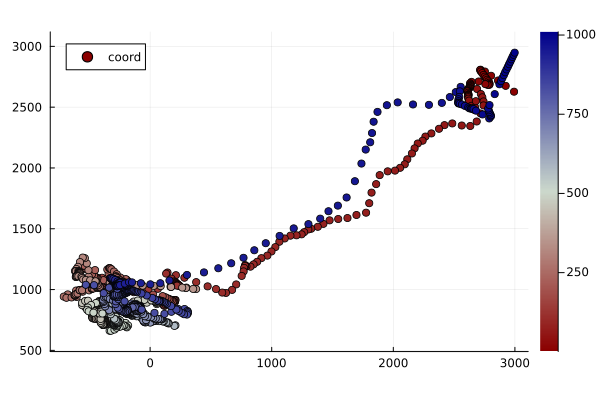

In [7]:
using Plots
get_coord(t::TargetPair) = (t[1], t[2])
get_speed(t::TargetPair) = t[3]
get_speed_abs(t::TargetPair) = get_speed(t) |> abs

seg = fst_segments[SEG_INDEX]
sliding_seg = sliding_window_continous(fst_segments[SEG_INDEX], WINDOW_SIZE)[1]
plot_seg = seg
time_steps = 1:length(plot_seg)
println("time_steps=$(length(time_steps))")
plot(plot_seg |> xs -> map(get_coord, xs), seriestype = :scatter, label = "coord", aspect_ratio = 1, zcolor = time_steps, color = :redsblues)

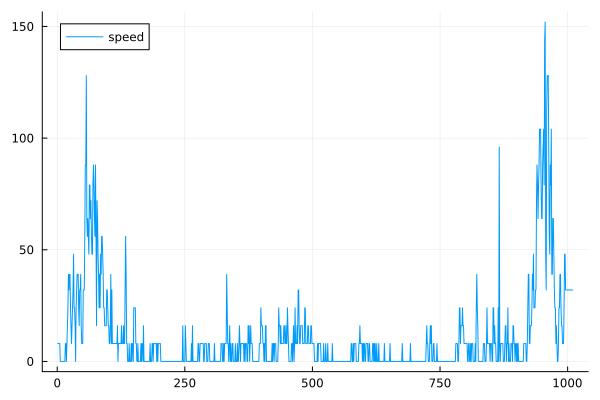

In [8]:
plot(seg |> xs -> map(get_speed_abs, xs), seriestype = :line, label = "speed")

In [9]:
using Statistics
speed_abs = seg |> xs -> map(get_speed_abs, xs)
speed_mean = mean(speed_abs)
speed_std = std(speed_abs)
println("speed_mean=$(speed_mean)cm/s")
println("speed_std=$(speed_std)cm/s")

speed_mean=11.462376237623763cm/s
speed_std=20.80184176246504cm/s


In [10]:
using FuzzyLogic
fis = @mamfis function decider(xAvg, yAvg, speedMean, speedStd)::output
    xAvg := begin
        domain = -1000:1000
        # left
        XL = GaussianMF(-1000.0, 200.0)
        # optimal
        XO = GaussianMF(-220.0, 180.0)
        # right
        XR = GaussianMF(500.0, 230.0)
    end
    yAvg := begin
        domain = -10:2000
        # optimal
        YO = GaussianMF(0.0, 750.0)
        # negative
        YN = GaussianMF(2000.0, 250.0)
    end
    speedMean := begin
        domain = 0:12
        # optimal
        SMO = ZShapeMF(6, 12)
        # high
        SMH = GaussianMF(15.0, 2.0)
    end
    speedStd := begin
        domain = 0:8
        # optimal
        SSO = ZShapeMF(4, 8)
        # high
        SSH = GaussianMF(8.0, 1.2)
    end
    output := begin
        domain = -1:1
        # false
        OF = GaussianMF(-1.0, 0.6)
        # true
        OT = GaussianMF(1.0, 0.6)
    end

    and = ProdAnd
    or = ProbSumOr
    implication = ProdImplication

    xAvg == XO && yAvg == YO && speedMean == SMO && speedStd == SSO --> output == OT
    # Others are default to L
    xAvg == XL --> output == OF
    xAvg == XR --> output == OF
    yAvg == YN --> output == OF
    speedMean == SMH --> output == OF
    speedStd == SSH --> output == OF
    # additional rules
    xAvg == XO && yAvg == YN --> output == OF
    xAvg == XL && speedMean == SMO --> output == OF
    xAvg == XR && speedMean == SMO --> output == OF
    yAvg == YO && speedMean == SMH --> output == OF
    yAvg == YO && speedStd == SSH --> output == OF

    aggregator = ProbSumAggregator
    defuzzifier = CentroidDefuzzifier
    # defuzzifier = BisectorDefuzzifier
end

decider

Inputs:
-------
xAvg ∈ [-1000, 1000] with membership functions:
    XL = GaussianMF{Float64}(-1000.0, 200.0)
    XO = GaussianMF{Float64}(-220.0, 180.0)
    XR = GaussianMF{Float64}(500.0, 230.0)

yAvg ∈ [-10, 2000] with membership functions:
    YO = GaussianMF{Float64}(0.0, 750.0)
    YN = GaussianMF{Float64}(2000.0, 250.0)

speedMean ∈ [0, 12] with membership functions:
    SMO = ZShapeMF{Int64}(6, 12)
    SMH = GaussianMF{Float64}(15.0, 2.0)

speedStd ∈ [0, 8] with membership functions:
    SSO = ZShapeMF{Int64}(4, 8)
    SSH = GaussianMF{Float64}(8.0, 1.2)


Outputs:
--------
output ∈ [-1, 1] with membership functions:
    OF = GaussianMF{Float64}(-1.0, 0.6)
    OT = GaussianMF{Float64}(1.0, 0.6)


Inference rules:
----------------
(xAvg is XO ∧ (yAvg is YO ∧ (speedMean is SMO ∧ speedStd is SSO))) --> output is OT
xAvg is XL --> output is OF
xAvg is XR --> output is OF
yAvg is YN --> output is OF
speedMean is SMH --> output is OF
speedStd is SSH --> output is OF
(xAvg is 

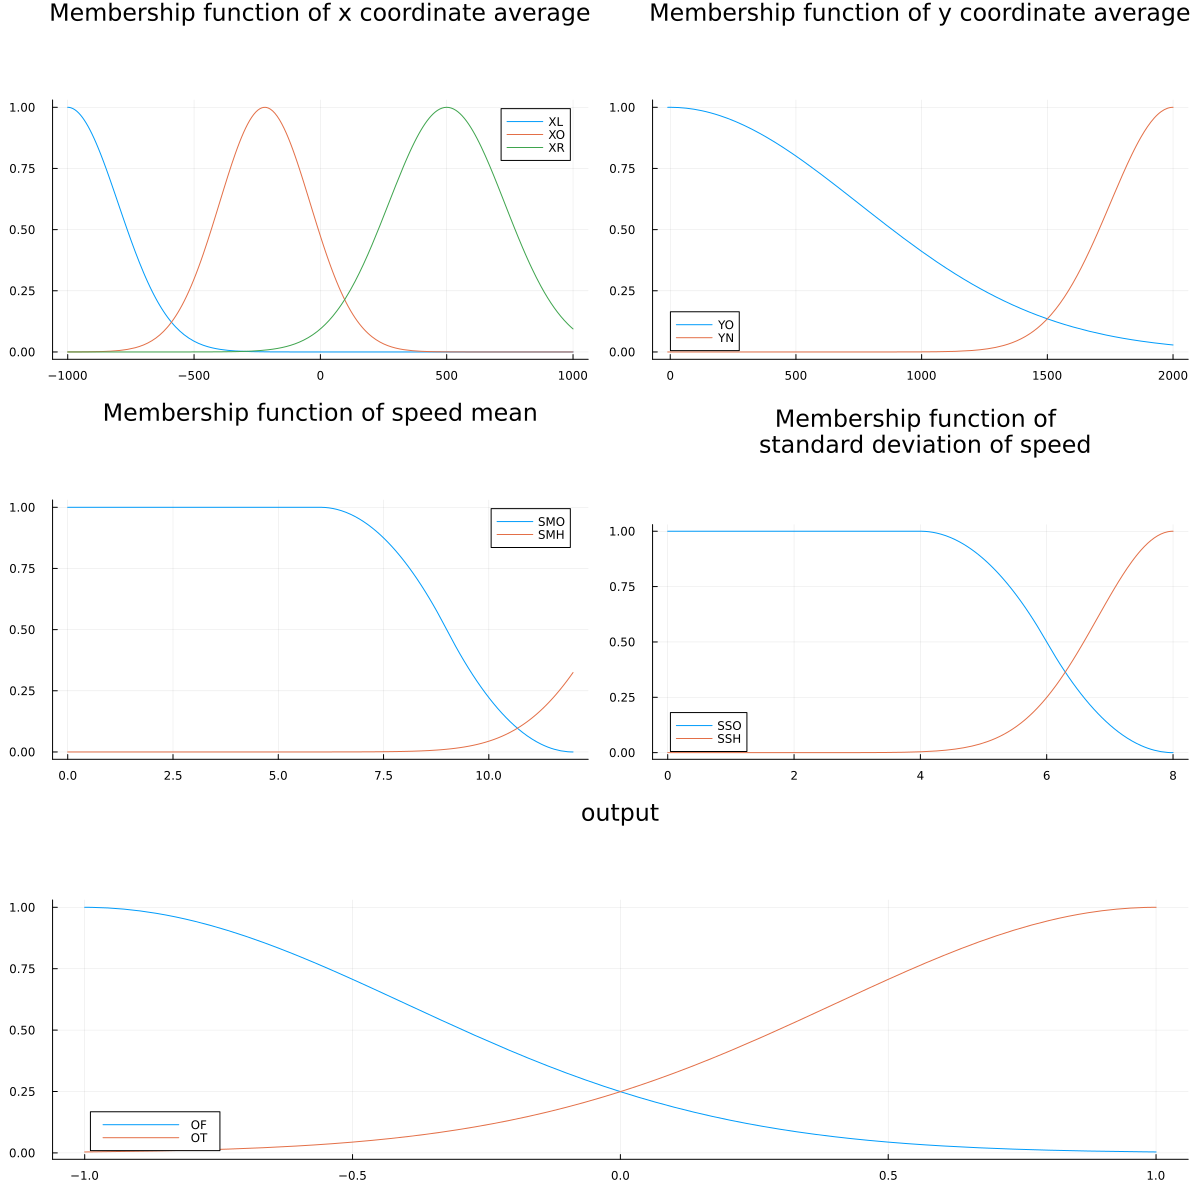

In [11]:
pXAvg = plot(fis, :xAvg)
# plot title and title are different
plot!(pXAvg, plot_title = "Membership function of x coordinate average")
pYAvg = plot(fis, :yAvg)
plot!(pYAvg, plot_title = "Membership function of y coordinate average")
pSpeedMean = plot(fis, :speedMean)
plot!(pSpeedMean, plot_title = "Membership function of speed mean")
pSpeedStd = plot(fis, :speedStd)
plot!(pSpeedStd, plot_title = "Membership function of \n standard deviation of speed")
pOutput = plot(fis, :output)
layout = @layout [a b; c d; e]
p = plot(pXAvg, pYAvg, pSpeedMean, pSpeedStd, pOutput, layout = layout, size = (1200, 1200))
display(p)

In [17]:
# https://github.com/JuliaLang/julia/issues/43491
function centroid(
    domain::UnitRange{Int},
    mf::Any,
    segmentation::Int=100,
)
    x = LinRange(first(domain), last(domain), segmentation)
    dx = (last(domain) - first(domain)) / (segmentation - 1)
    y = map(mf, x)
    trapz(dx, y) = (2sum(y) - first(y) - last(y)) * dx / 2
    ∫f = trapz(dx, y)
    ∫xf = trapz(dx, x .* y)
    centroid_x = ∫xf / ∫f
end

maxVal = centroid(-1:1, GaussianMF(1.0, 0.6))
minVal = centroid(-1:1, GaussianMF(-1.0, 0.6))
display("maxVal=$(maxVal); minVal=$(minVal)")

"maxVal=0.522756999898516; minVal=-0.522756999898516"

In [18]:
function mapRange(
    x::Real,
    inMin::Real,
    inMax::Real,
    outMin::Real,
    outMax::Real,
)::Real
    (x - inMin) * (outMax - outMin) / (inMax - inMin) + outMin
end

Base.Meta.ParseError: ParseError:
# Error @ /Users/crosstyan/Code/radar/play_jl.ipynb:9:112
    return (x - inMin) * (outMax - outMin) / (inMax - inMin) + outMin
# fis(xAvg = -200, yAvg = 500, speedMean = 8, speedStd = 4)[:output] |> x -> mapRange(x, minVal, maxVal, -1, 1)
#                                                                                                              └ ── Expected `end`

each_length=[1010]; current_length=997


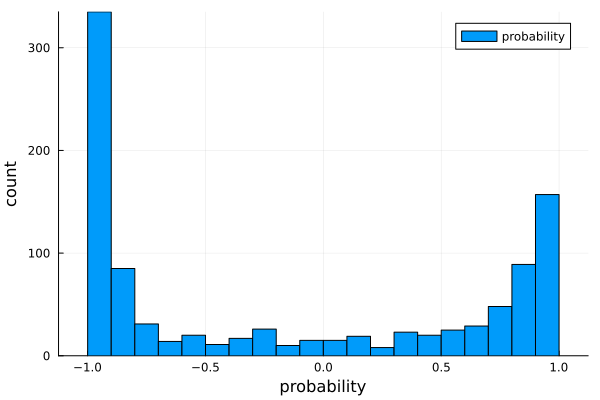

In [19]:
slidings = sliding_window_continous(fst_segments[SEG_INDEX], WINDOW_SIZE)

function targetsWindow2Fuzzy(
    target::AbstractArray{TargetPair},
)::Real
    xAvg = map(x -> x[1], target) |> mean
    yAvg = map(x -> x[2], target) |> mean
    # note that speed should be positive
    speed = map(x -> x[3] |> abs, target)
    speedAvg = mean(speed)
    speedStd = std(speed)
    calc(xAvg, yAvg, speedAvg, speedStd) = fis(xAvg = xAvg, yAvg = yAvg, speedMean = speedAvg, speedStd = speedStd)[:output] |> x -> mapRange(x, minVal, maxVal, -1, 1)
    calc(xAvg, yAvg, speedAvg, speedStd)
end

println("each_length=$(each_length); current_length=$(length(slidings))")
prob = map(targetsWindow2Fuzzy, slidings)
histogram(prob, bins = 20, label = "probability", xlabel = "probability", ylabel = "count")

time_steps=14


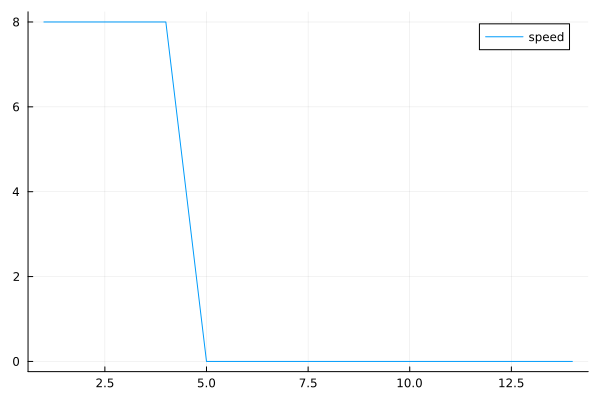

In [20]:
# get the corresponding windows index
prob_less_than_0_index = filter(x -> prob[x] < 0, 1:length(prob))
# get the corresponding windows
prob_less_than_0_windows = map(x -> slidings[x], prob_less_than_0_index)
# xx
plot_seg = prob_less_than_0_windows[2]
time_steps = 1:length(plot_seg)
# display(prob_less_than_0_index)
println("time_steps=$(length(time_steps))")
# plot(plot_seg |> xs -> map(get_coord, xs), seriestype = :scatter, label = "coord", aspect_ratio = 1, zcolor = time_steps, color = :redsblues)
plot(plot_seg |> xs -> map(x -> get_speed(x) |> abs, xs), seriestype = :line, label = "speed")